In [1]:
# !pip install tensorflow keras

In [2]:
import os
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# **Thiết lập cấu hình, Load dữ liệu**

In [3]:
FILE_PATH = "/content/drive/MyDrive/Dữ liệu/BK_20_Test_3_clean.csv"
OLD_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/Best_model_LSTM.keras"
NEW_MODEL_OUT = "retrained_best_model.keras"

TIMESTEPS = 120          # Cửa sổ quan sát
SAVGOL_WINDOW = 11
SAVGOL_POLY = 2
TEST_RATIO = 0.2
RANDOM_SEED = 42
BATCH_SIZE = 32
EPOCHS = 100

In [4]:
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Load dữ liệu

In [5]:
df = pd.read_csv(FILE_PATH)
print("Loaded shape:", df.shape)

Loaded shape: (1693, 19)


#**Xử lý dữ liệu, tạo đặc trưng**

In [6]:
# Tạo các cột trung bình (4 features)
pairs = [
    ('Annulus pressure', 'Annulus pressure min', 'Annulus pressure max'),
    ('Buffer pressure', 'Buffer pressure min', 'Buffer pressure max'),
    ('Flow pressure', 'Flow pressure min', 'Flow pressure max'),
    ('T', 'T min', 'T max')
]
for name, col_min, col_max in pairs:
    if col_min in df.columns and col_max in df.columns:
        df[f'{name}_avg'] = (df[col_min] + df[col_max]) / 2

In [7]:
# Xử lý Outlier và Smooth Qliq
if 'Qliq' in df.columns:
    # Điền khuyết sơ bộ
    df['Qliq'] = df['Qliq'].fillna(method='ffill').fillna(method='bfill')

    # --- FIX 1: Chia tách dữ liệu trước khi fit bộ lọc nhiễu ---
    # Xác định điểm cắt Train/Test theo thời gian
    train_size = int(len(df) * (1 - TEST_RATIO))

    # Huấn luyện Isolation Forest CHỈ trên tập Train
    iso = IsolationForest(contamination=0.01, random_state=RANDOM_SEED)
    # Lấy dữ liệu train để fit
    train_qliq = df['Qliq'].iloc[:train_size].values.reshape(-1, 1)
    iso.fit(train_qliq)

    # --- FIX 2: Không Drop dòng, chỉ thay thế và nội suy ---
    # Dự báo outlier trên toàn bộ dữ liệu (sử dụng luật đã học từ Train)
    outlier_labels = iso.predict(df[['Qliq']].values) # -1 là outlier, 1 là inlier

    # Gán các điểm outlier thành NaN
    df.loc[outlier_labels == -1, 'Qliq'] = np.nan

    # Nội suy để lấp đầy (Giữ tính liên tục của thời gian)
    df['Qliq'] = df['Qliq'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

    # --- FIX 3: Thay Savgol (nhìn tương lai) bằng EWM (chỉ nhìn quá khứ) ---
    # Savgol filter thường lấy cửa sổ đối xứng (ví dụ t-5 đến t+5), nên tại t đã biết t+5 -> Leak.
    # Dùng EWM (Exponential Weighted Moving Average) để làm trơn an toàn.
    df['Qliq_smooth'] = df['Qliq'].ewm(span=11).mean()
else:
    print("⚠️ Cột Qliq không tồn tại!")
    df['Qliq_smooth'] = 0

/tmp/ipython-input-3245366904.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Qliq'] = df['Qliq'].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-3245366904.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Qliq'] = df['Qliq'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


Tạo các biến dẫn xuất (Derived Features)

In [8]:
# Tốc độ thay đổi (3 features)
df['dQliq'] = df['Qliq_smooth'].diff().fillna(0)
df['dGI'] = df['Gas injection rate'].diff().fillna(0) if 'Gas injection rate' in df.columns else 0
df['dFlowP'] = df['Flow pressure_avg'].diff().fillna(0) if 'Flow pressure_avg' in df.columns else 0

In [9]:
# Đường trung bình động - Moving Averages (2 features)
df['Qliq_ma7'] = df['Qliq_smooth'].rolling(7, min_periods=1).mean()
df['Qliq_ma21'] = df['Qliq_smooth'].rolling(21, min_periods=1).mean()

In [10]:
# Đanh dấu sự kiện - Event Markers (2 features)
df['drop_pct_3'] = df['Qliq_smooth'].pct_change(3).fillna(0)
df['event_shutin'] = (df['drop_pct_3'] < -0.40).astype(int)
df['event_restart'] = ((df['drop_pct_3'] > 0.40) & (df['Qliq_smooth'] < df['Qliq_ma7'])).astype(int)

Thiết lập danh sách đặc trưng đầu vào

In [11]:
feature_seq = [
    'Annulus pressure_avg','Flow pressure_avg', 'T_avg',
    'Gas injection rate', 'Choke',
    'dQliq', 'dGI','dFlowP',
    'Qliq_ma7', 'Qliq_ma21',
    'drop_pct_3', 'event_restart','event_shutin'
]

In [12]:
TARGET = 'Qliq'

In [13]:
# Drop các dòng thiếu dữ liệu
df_clean = df.dropna(subset=feature_seq + [TARGET]).reset_index(drop=True)
print(f" Số lượng Features đầu vào: {len(feature_seq)}")
print(f" Kích thước dữ liệu sau khi làm sạch: {df_clean.shape}")

 Số lượng Features đầu vào: 13
 Kích thước dữ liệu sau khi làm sạch: (1693, 32)


# TẠO DATASET (CREATE SEQUENCES)

In [14]:
# Hàm tạo sequences
def create_sequences(df_, seq_features, target, timesteps):
    X, Y = [], []
    # Lưu ý: Index phải liên tục
    data_x = df_[seq_features].values
    data_y = df_[target].values

    for i in range(timesteps, len(df_)):
        X.append(data_x[i-timesteps:i]) # Lấy từ t-window đến t-1
        Y.append(data_y[i])             # Dự báo tại t
    return np.array(X), np.array(Y).reshape(-1,1)

X_all, Y_all = create_sequences(df_clean, feature_seq, TARGET, TIMESTEPS)

# SPLIT & SCALE

In [15]:
# Chia Train/Test
n_train = int(len(X_all) * (1 - TEST_RATIO))
X_train, X_test = X_all[:n_train], X_all[n_train:]
Y_train, Y_test = Y_all[:n_train], Y_all[n_train:]

In [16]:
# Scaling
scalers = [MinMaxScaler() for _ in range(len(feature_seq))]
X_train_s = np.zeros_like(X_train)
X_test_s = np.zeros_like(X_test)

for i in range(len(feature_seq)):
    scalers[i].fit(X_train[:,:,i].reshape(-1,1))
    X_train_s[:,:,i] = scalers[i].transform(X_train[:,:,i].reshape(-1,1)).reshape(X_train.shape[0], TIMESTEPS)
    X_test_s[:,:,i] = scalers[i].transform(X_test[:,:,i].reshape(-1,1)).reshape(X_test.shape[0], TIMESTEPS)

scaler_y = MinMaxScaler()
Y_train_s = scaler_y.fit_transform(Y_train)
Y_test_s = scaler_y.transform(Y_test)

# MODEL DEFINITION (UPDATE THEO FOUND MODEL)

In [17]:
@tf.keras.utils.register_keras_serializable()
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],1), initializer='glorot_uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)
    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu, axis=1)
        output = tf.reduce_sum(inputs * alphas, axis=1)
        return output
    def get_config(self): return super().get_config()

In [18]:
# --- Kiến trúc Single-Input (Khớp file .keras cũ) ---
inp = Input(shape=(TIMESTEPS, 13), name='seq_input')

In [19]:
# Lớp 1: Bi-LSTM 128 (Output 256) - Khớp weights cũ
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True), name='bidirectional')(inp)

In [20]:
# Lớp 2: Bi-LSTM 64 (Output 128) - Khớp weights cũ
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True), name='bidirectional_1')(x)

In [21]:
x = layers.Dropout(0.2, name='dropout')(x)
att = AttentionLayer(name='attention_layer')(x)

In [22]:
# --- Các lớp Dense (Theo đúng thứ tự trong log) ---
x = layers.Dense(64, activation='relu', name='dense')(att)
x = layers.Dense(64, activation='relu', name='dense_1')(x)
x = layers.Dropout(0.15, name='dropout_1')(x)
x = layers.Dense(32, activation='relu', name='dense_2')(x)
out = layers.Dense(1, activation='linear', name='dense_3')(x)

In [23]:
model = Model(inputs=inp, outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ seq_input (InputLayer)          │ (None, 120, 13)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 120, 256)       │       145,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 120, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 128)            │        16,640 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,929 (1.30 MB)

 Trainable params: 340,929 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

# LOAD WEIGHTS (NẠP TRỌNG SỐ ĐÃ TÌM ĐƯỢC)

In [24]:
print("\n>>> Đang nạp trọng số từ file cũ...")

try:
    if os.path.exists(OLD_MODEL_PATH):
        old_model = load_model(OLD_MODEL_PATH, custom_objects={'AttentionLayer': AttentionLayer})

        # Danh sách lớp cần nạp (Dựa theo Log cấu trúc)
        layers_to_load = [
            'bidirectional', 'bidirectional_1', 'attention_layer',
            'dense', 'dense_1', 'dense_2', 'dense_3'
        ]

        count = 0
        for name in layers_to_load:
            try:
                w = old_model.get_layer(name).get_weights()
                model.get_layer(name).set_weights(w)
                count += 1
                print(f"   ✅ Đã nạp: {name}")
            except Exception as e:
                print(f"   ⚠️ Lỗi nạp {name}: {e}")

        print(f"✅ Hoàn tất nạp {count} lớp. Model sẵn sàng!")
        del old_model
    else:
        print("⚠️ Không tìm thấy file model cũ. Sẽ train từ đầu.")
except Exception as e:
    print(f"❌ Lỗi nạp model: {e}")


>>> Đang nạp trọng số từ file cũ...
   ⚠️ Lỗi nạp bidirectional: Layer bidirectional weight shape (13, 512) is not compatible with provided weight shape (11, 512).
   ✅ Đã nạp: bidirectional_1
   ✅ Đã nạp: attention_layer
   ✅ Đã nạp: dense
   ✅ Đã nạp: dense_1
   ✅ Đã nạp: dense_2
   ✅ Đã nạp: dense_3
✅ Hoàn tất nạp 6 lớp. Model sẵn sàng!


# HUẤN LUYỆN (TRAINING)

In [25]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    ModelCheckpoint(NEW_MODEL_OUT, monitor='val_loss', save_best_only=True)
]

In [26]:
# Chỉ dùng X_train_s (Single Input)
hist = model.fit(
    X_train_s, Y_train_s,
    validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE,
    callbacks=callbacks, verbose=1
)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.0165 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0102 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0076 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0060 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0060 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0061 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0055 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0051 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0051 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 10/1

# DỰ BÁO & ĐÁNH GIÁ


In [27]:
y_pred = scaler_y.inverse_transform(model.predict(X_test_s))
y_true = scaler_y.inverse_transform(Y_test_s)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


In [28]:
# RMSE & R2 cho Qliq
def rmse(a, b): return np.sqrt(mean_squared_error(a, b))
print("-" * 30)
print(f" Q_liq RMSE: {rmse(y_true, y_pred):.4f}")
print(f" Q_liq R2:   {r2_score(y_true, y_pred):.4f}")
print("-" * 30)

------------------------------
 Q_liq RMSE: 8.0535
 Q_liq R2:   0.6242
------------------------------


In [29]:
# TÍNH TOÁN Q_OIL
# Lấy lại index tương ứng của tập test trong df_clean
test_idx = range(n_train + TIMESTEPS, n_train + TIMESTEPS + len(y_pred))
ref_data = df_clean.iloc[test_idx].copy()

In [30]:
if 'Water cut' in ref_data.columns:
    wc = ref_data['Water cut'].values.reshape(-1,1)
    # Xử lý đơn vị %
    if np.nanmax(wc) > 1.0: wc /= 100.0

    # Công thức: Qoil = Qliq * (1 - WC)
    y_pred_qoil = np.maximum(y_pred * (1 - wc), 0)

    if 'Qoil' in ref_data.columns:
        qoil_true = ref_data['Qoil'].values.reshape(-1,1)
        print(f" Q_oil RMSE: {rmse(qoil_true, y_pred_qoil):.4f}")
        print(f" Q_oil R2:   {r2_score(qoil_true, y_pred_qoil):.4f}")

 Q_oil RMSE: 2.3161
 Q_oil R2:   0.8584


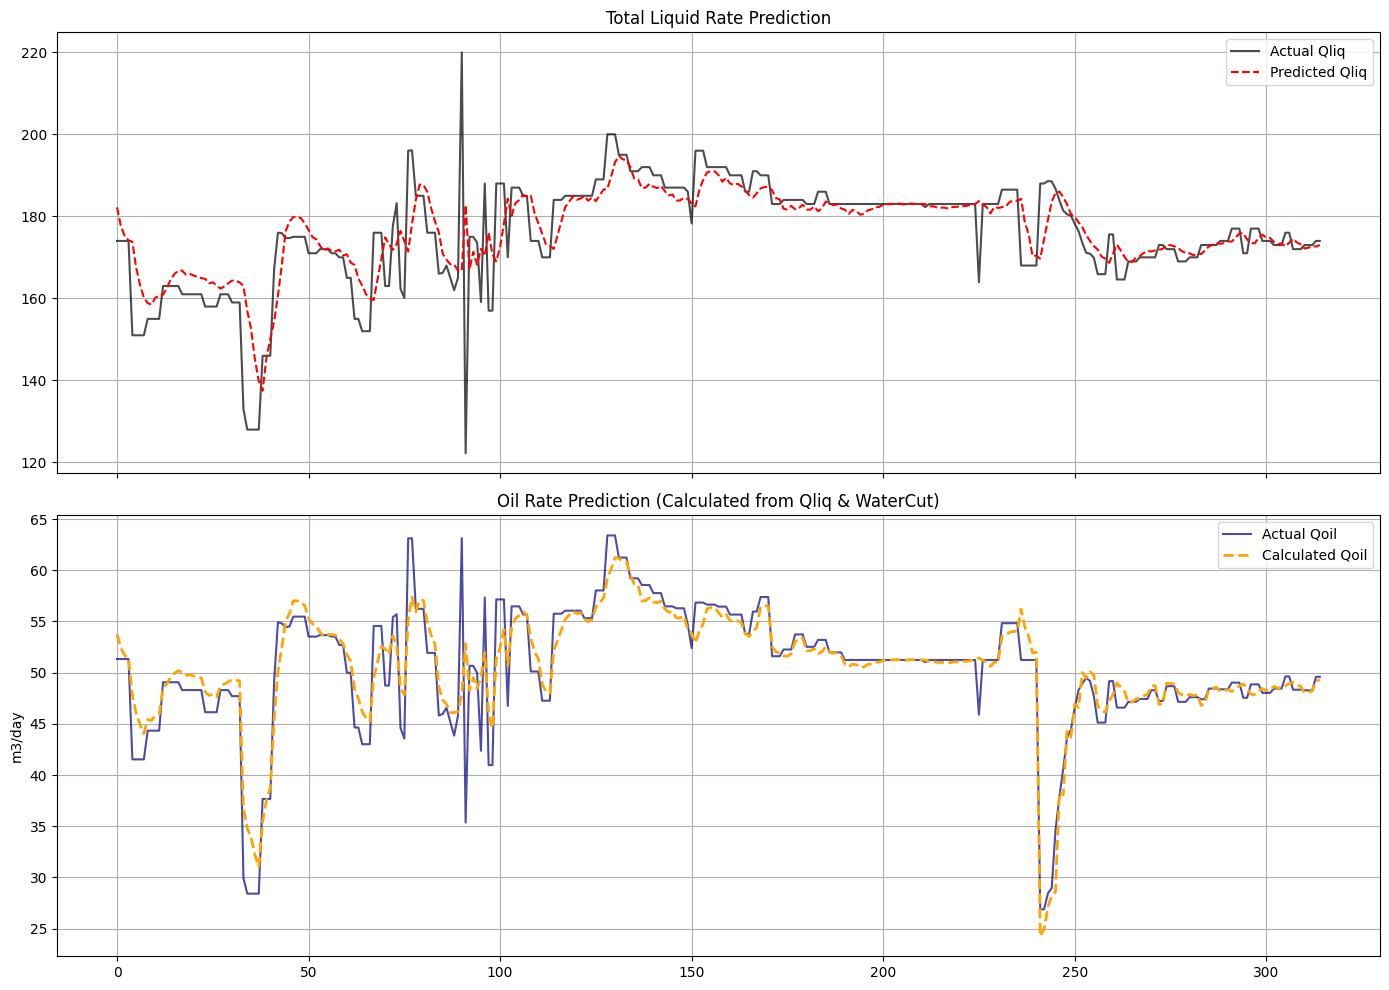

In [31]:
# Vẽ biểu đồ so sánh
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1.plot(y_true, label='Actual Qliq', color='black', alpha=0.7)
ax1.plot(y_pred, label='Predicted Qliq', color='red', linestyle='--')
ax1.set_title('Total Liquid Rate Prediction')
ax1.legend(); ax1.grid(True)

if 'Qoil' in ref_data.columns:
    ax2.plot(qoil_true, label='Actual Qoil', color='navy', alpha=0.7)
ax2.plot(y_pred_qoil, label='Calculated Qoil', color='orange', linestyle='--', linewidth=2)
ax2.set_title('Oil Rate Prediction (Calculated from Qliq & WaterCut)')
ax2.set_ylabel('m3/day')
ax2.legend(); ax2.grid(True)

plt.tight_layout()
plt.show()

# Lưu model

In [35]:
#model_name = 'Model_LSTM.keras'
#model.save(model_name)
#print(f"Đã lưu model {model_name}")

Đã lưu model Model_LSTM.keras


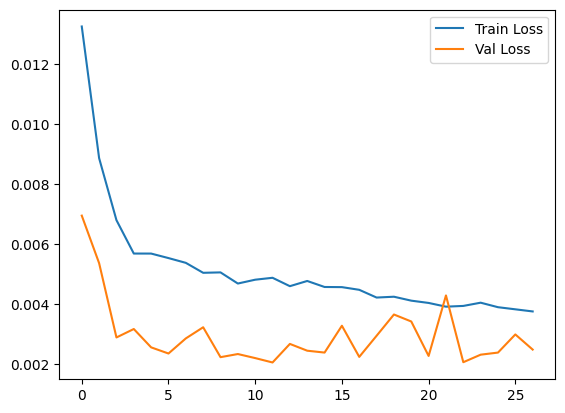

In [33]:
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

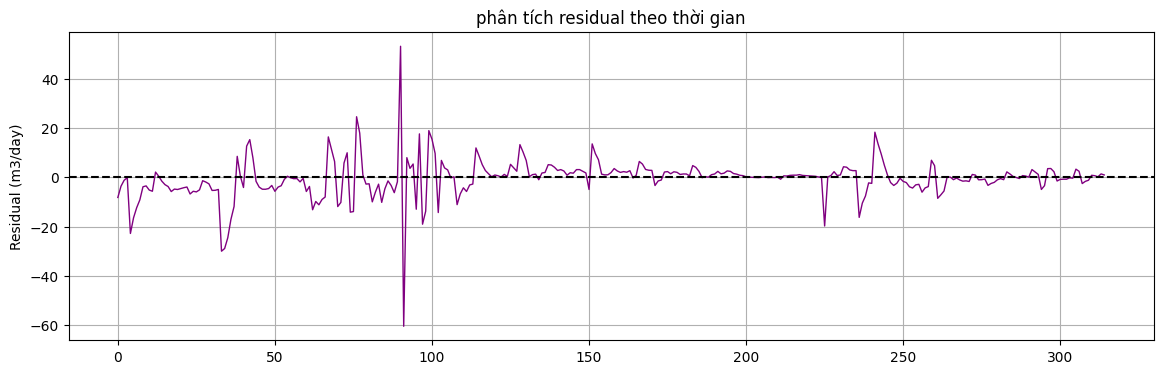

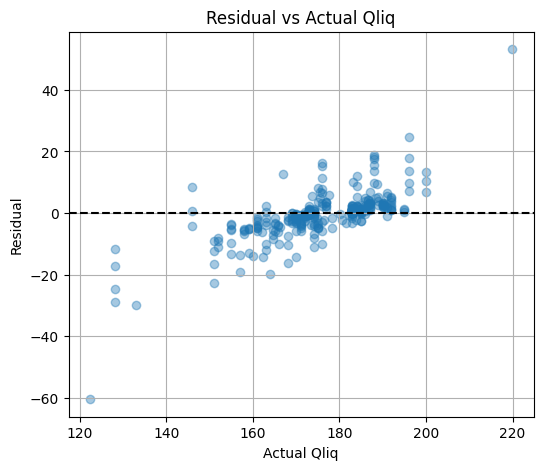

In [34]:
# phân tích residual theo thời gian
residual = y_true.flatten() - y_pred.flatten()

plt.figure(figsize=(14,4))
plt.plot(residual, color='purple', linewidth=1)
plt.axhline(0, color='black', linestyle='--')
plt.title("phân tích residual theo thời gian")
plt.ylabel("Residual (m3/day)")
plt.grid(True)
plt.show()

# Residual vs Qliq (heteroscedasticity)
plt.figure(figsize=(6,5))
plt.scatter(y_true, residual, alpha=0.4)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Actual Qliq")
plt.ylabel("Residual")
plt.title("Residual vs Actual Qliq")
plt.grid(True)
plt.show()